<a href="https://colab.research.google.com/github/CobaMasa/PythonKerasDeeplearning/blob/main/chapter5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter5: Deep Learning for Computer Vision
Contents:
- Overview of CNN
- How to handle overfitting problems
    - Data augmentation
    - Using a pre-trained CNN
    - Fine-tuning pre-trained model
- Visualization of what CNN learned from data & how it got to the conclusion.

## - How to handle overfitting problems
### Using a pre-trained CNN

In [1]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
display(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

None

In [2]:
# List 5-17: Feature extraction with pre-trained CNN
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'drive/My Drive/Study/PythonKeras/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255.)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    
    i = 0
    for input_batch, labels_batch in generator:
        feature_batch = conv_base.predict(input_batch)
        features[i * batch_size: (i+1) * batch_size] = feature_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
# reshape data to adjust for dense layers
train_features = train_features.reshape(len(train_features), -1)
validation_features = validation_features.reshape(len(validation_features), -1)
test_features = test_features.reshape(len(test_features), -1)

In [4]:
## Unable to use data augmentation
# List 5-18: Define fully connected layer and train it (with functional API)
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

inputs = Input(train_features.shape[1])
x = Dense(256, activation='relu')(inputs)
x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels,epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.6134 - acc: 0.6530 - val_loss: 0.4540 - val_acc: 0.8200
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4308 - acc: 0.8050 - val_loss: 0.3657 - val_acc: 0.8710
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3632 - acc: 0.8410 - val_loss: 0.3292 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3167 - acc: 0.8620 - val_loss: 0.3066 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2856 - acc: 0.8885 - val_loss: 0.2902 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2657 - acc: 0.8945 - val_loss: 0.2744 - val_acc: 0.8980
Epoch 7/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2420 - acc: 0.9020 - val_loss: 0.2635 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1s 5ms/step - loss: 0.

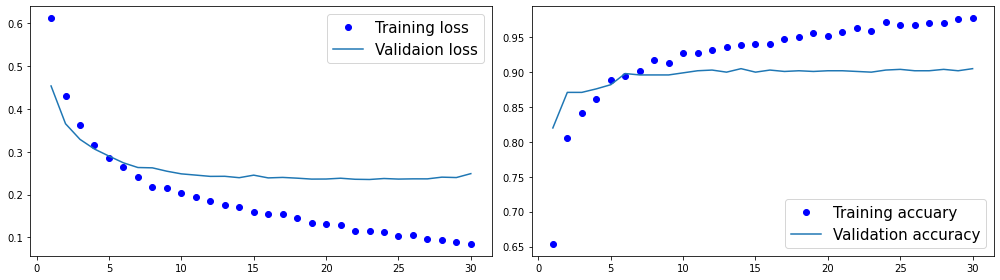

In [5]:
# List 5-19: Plotting the results
import matplotlib.pyplot as plt
n_epochs = range(1, 31)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(n_epochs, train_loss, 'bo', label='Training loss')
ax[0].plot(n_epochs, val_loss, label='Validaion loss')
ax[0].legend(fontsize=15)

ax[1].plot(n_epochs, train_acc, 'bo', label='Training accuary')
ax[1].plot(n_epochs, val_acc, label='Validation accuracy')
ax[1].legend(fontsize=15)
plt.tight_layout()
plt.show();

In [6]:
## able to use Data augmentation
# List 5-20: Add fully connected layer to convolutional base
x = Flatten()(conv_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=prediction)
conv_base.trainable = False
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
display(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

None

In [7]:
# List 5-21: Train whole network
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=20
)

history = model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    validation_steps=50, verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 28s - loss: 0.7107 - acc: 0.5660 - val_loss: 0.5233 - val_acc: 0.7830
Epoch 2/30
100/100 - 28s - loss: 0.5734 - acc: 0.7125 - val_loss: 0.4354 - val_acc: 0.8300
Epoch 3/30
100/100 - 28s - loss: 0.5214 - acc: 0.7430 - val_loss: 0.3869 - val_acc: 0.8490
Epoch 4/30
100/100 - 28s - loss: 0.4716 - acc: 0.7815 - val_loss: 0.3594 - val_acc: 0.8480
Epoch 5/30
100/100 - 28s - loss: 0.4533 - acc: 0.7855 - val_loss: 0.3428 - val_acc: 0.8660
Epoch 6/30
100/100 - 28s - loss: 0.4334 - acc: 0.7990 - val_loss: 0.3348 - val_acc: 0.8660
Epoch 7/30
100/100 - 28s - loss: 0.4255 - acc: 0.8070 - val_loss: 0.3119 - val_acc: 0.8830
Epoch 8/30
100/100 - 28s - loss: 0.4101 - acc: 0.8105 - val_loss: 0.3018 - val_acc: 0.8820
Epoch 9/30
100/100 - 28s - loss: 0.3952 - acc: 0.8145 - val_loss: 0.2983 - val_acc: 0.8800
Epoch 10/30
100/100 - 28s - loss: 0.3816 - acc: 0.8320 - val_loss: 0.2889 - val_acc: 0.8880
Epoch

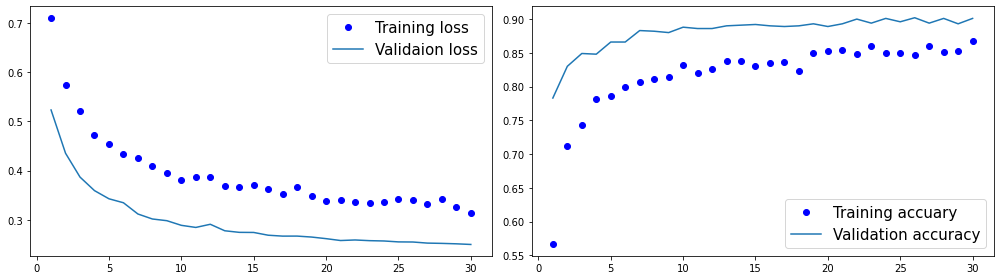

In [8]:
n_epochs = range(1, 31)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(n_epochs, train_loss, 'bo', label='Training loss')
ax[0].plot(n_epochs, val_loss, label='Validaion loss')
ax[0].legend(fontsize=15)

ax[1].plot(n_epochs, train_acc, 'bo', label='Training accuary')
ax[1].plot(n_epochs, val_acc, label='Validation accuracy')
ax[1].legend(fontsize=15)
plt.tight_layout()
plt.show();

### Fine-tuning pre-trained model
steps:
1. Add custom (ex.fully connected) network back of pre-trained model.
2. Freeze weights in base network (which means pre-trained model)
3. Train whole network.
4. Defreeze some of frozen weights (or layers), and keep going.
5. Fine tuned!!!

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
# List5-22 & 23: Freeze layers from head to a specific layer
conv_base.trainable = True
for layer in conv_base.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 30s 296ms/step - loss: 0.3171 - acc: 0.8610 - val_loss: 0.2247 - val_acc: 0.9080
Epoch 2/100
100/100 [==============================] - 29s 295ms/step - loss: 0.2824 - acc: 0.8795 - val_loss: 0.2229 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 29s 293ms/step - loss: 0.2470 - acc: 0.8955 - val_loss: 0.2029 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 29s 292ms/step - loss: 0.2395 - acc: 0.8960 - val_loss: 0.1913 - val_acc: 0.9210
Epoch 5/100
100/100 [==============================] - 29s 292ms/step - loss: 0.2303 - acc: 0.8970 - val_loss: 0.1818 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 30s 296ms/step - loss: 0.2135 - acc: 0.9155 - val_loss: 0.1787 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 29s 293ms/step - loss: 0.1829 - acc: 0.9215 - val_loss: 0.1931 - val_acc: 0.9280
Epoch 8/100
100/100 [===========================

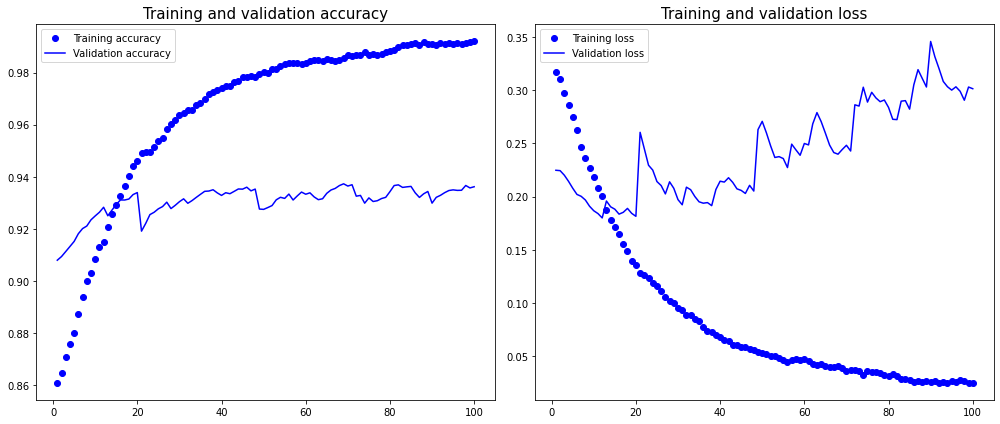

In [11]:
# List 5-24: Smoothing plot
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

n_epochs = range(1, 101)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Accucary
ax[0].plot(n_epochs, smooth_curve(history.history['acc']), 'bo', label='Training accuracy')
ax[0].plot(n_epochs, smooth_curve(history.history['val_acc']), 'b', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy', fontsize=15)
ax[0].legend()

# Loss
ax[1].plot(n_epochs, smooth_curve(history.history['loss']), 'bo', label='Training loss')
ax[1].plot(n_epochs, smooth_curve(history.history['val_loss']), 'b', label='Validation loss')
ax[1].set_title('Training and validation loss', fontsize=15)
ax[1].legend()

plt.tight_layout()
plt.show();

In [12]:
# In the end, use test data and check model performance
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Test ACC: {:.5f}'.format(test_acc))

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 6s 117ms/step - loss: 0.3818 - acc: 0.9320
Test ACC: 0.93200
